In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 08 08:44:19 2017

@author: greliert

** ADVANCED LANE FINDING **
Project #3 of the first term of Udacity's Self Driving Car nanodegree program

Objective of this project is to detect lane boundaries and estimate lane 
curvature and vehicle position.
Note: This script works only on images. A different script exists for processing videos.

The steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

"""

#%% import useful modules
import numpy as np
import cv2
import pickle
from pipeline_functions import *
%matplotlib inline

Input image:.\test_images_videos\test2.jpg


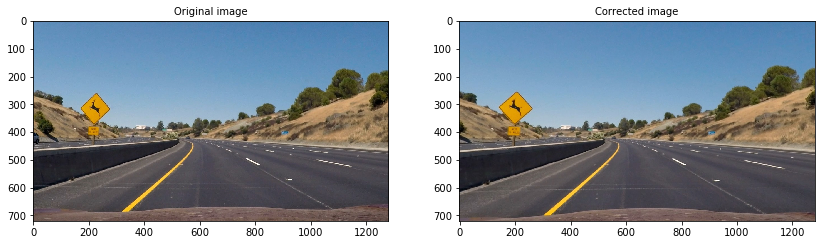

In [2]:
#%% Parameters
# Camera calibration
calibrate = 'no'   # 'yes'=perform calibration, 'load'= load coefficients
calib_dir = '.\\camera_cal\\'  # directory containing the calibration images and saved parameters
# Image to process
image_path = '.\\test_images_videos\\test2.jpg' # image file path

#%% PIPELINE
# 1) If not done, compute the camera calibration matrix and distortion 
# coefficients given a set of chessboard images.
n_corners = (9,6)  # nb of corners of chessboard
if calibrate == 'yes':
    ret, mtx, dist = calib_camera(calib_dir, n_corners)
    # Print an example of undistorted image
    img_test = cv2.imread(calib_dir+'calibration2.jpg')
    dst = cv2.undistort(img_test, mtx, dist, None, mtx)
    # plot and save
    subplot_save_img(img_test,dst,calib_dir+'calibration2_undist.png',title=['Original image','Corrected image'])
else: # load saved coefficients
    dist_pickle = pickle.load(open(calib_dir+'calib.p', "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
 
# 2) Apply a distortion correction to raw images.
img = cv2.imread(image_path)
print('Input image:{}'.format(image_path))
# Convert to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Distortion correction
img_undist = cv2.undistort(img, mtx, dist, None, mtx)
# plot and save
subplot_save_img(img,img_undist,image_path[:-4]+'_undist.jpg',title=['Original image','Corrected image'])

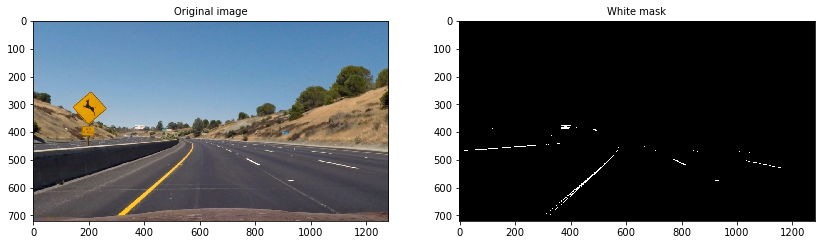

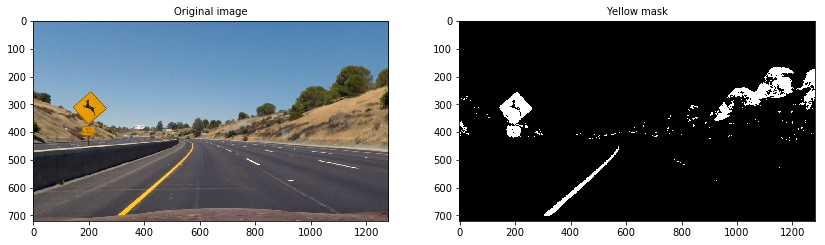

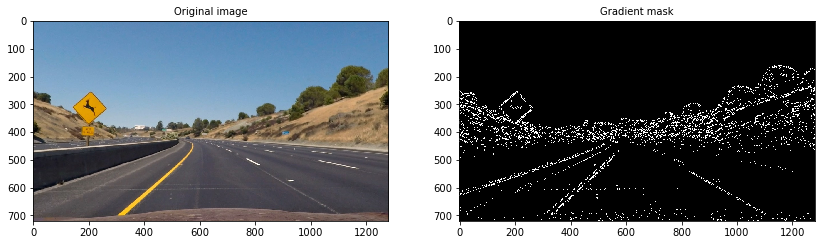

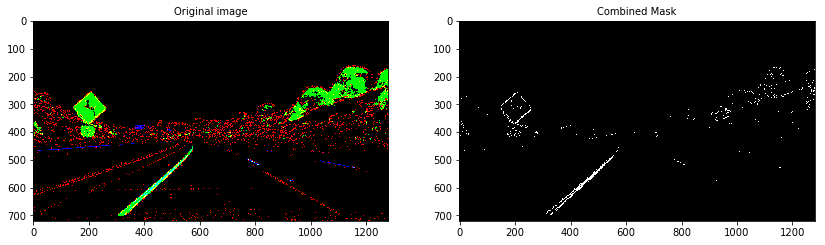

In [3]:
#%% 3) Use color transforms, gradients, etc., to create a thresholded binary image.

ksize = 3   # kernel size for gradient computation
# Compute masks based on gradients (x,y,magnitude,direction)
gradx = abs_sobel_thresh(img_undist, 'x', ksize, (30, 255))
grady = abs_sobel_thresh(img_undist, 'y', ksize, (30, 255))
mag_binary = mag_thresh(img_undist, ksize, (50, 255))
dir_binary = dir_thresh(img_undist, ksize, (40/180.*np.pi, 75/180.*np.pi))
# Combine gradient masks
grad_binary = np.zeros_like(dir_binary)
sel = 1  # select mask
if sel==0:
    grad_binary[((gradx == 1) & (grady == 1))] = 1
elif sel==1:
    grad_binary[(mag_binary == 1) & (dir_binary == 1)] = 1 
elif sel==2:
    grad_binary[(mag_binary == 1)] = 1 

# Compute mask based on color components
# Saturation
satu_binary = color_thresh(img_undist, 'HLS', [[0,255],[0,255],[100,255]])  
# Yellow: Hue value between 
yel_binary = color_thresh(img_undist, 'HLS', [[18,35],[0,255],[80,255]])
# White: Hue value between 
whi_binary = color_thresh(img_undist, 'GRAY', [[200,255]])
# Combine color and gradient mask
mask = np.zeros_like(dir_binary)
#mask[(satu_binary == 1) | (grad_binary == 1)] = 1
mask[(whi_binary+yel_binary+grad_binary)>=2] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
mask_binary = np.dstack((grad_binary, yel_binary, whi_binary))*255

# plot and save
subplot_save_img(img_undist,whi_binary,image_path[:-4]+'_white_mask.jpg',cmap=['jet','gray'],title=['Original image','White mask'])
subplot_save_img(img_undist,yel_binary,image_path[:-4]+'_yel_mask.jpg',cmap=['jet','gray'],title=['Original image','Yellow mask'])
subplot_save_img(img_undist,grad_binary,image_path[:-4]+'_grad_mask.jpg',cmap=['jet','gray'],title=['Original image','Gradient mask'])
#subplot_save_img(img_undist,satu_binary,image_path[:-4]+'_sat_mask.jpg',cmap=['jet','gray'],title=['Original image','Saturation mask'])
subplot_save_img(mask_binary,mask,image_path[:-4]+'_comb_mask.jpg',cmap=['jet','gray'],title=['Original image','Combined Mask'])

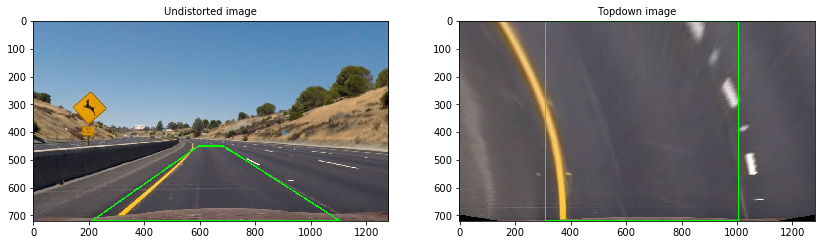

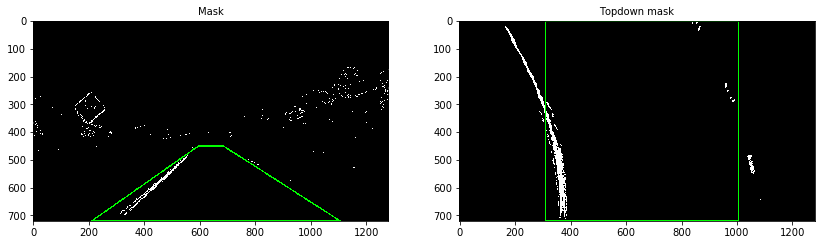

In [4]:
#%% 4) Apply a perspective transform to rectify binary image ("birds-eye view").
y_size, x_size= mask.shape

# Select the 4 quadrangle vertices in the original images that will be used
# for the perspective transform
xdl, ydl = 200+10, y_size        # down left
xdr, ydr = x_size-200+25, y_size # down right
xul, yul = 637, 420           # up left
xur, yur = 639, 420           # up right
al = float(ydl-yul)/float(xdl-xul)
ar = float(ydr-yur)/float(xdr-xur)
bl = ydl-al*xdl
br = ydr-ar*xdr
yul, yur = 450, 450 
xul, xur = (yul-bl)/al, (yur-br)/ar 
src_points = np.float32([[xdl,ydl],[xdr,ydr],[xur,yur],[xul,yul]])

# Select the corresponding 4 points in the destination images to which will be mapped the
# source points
# we take same y-values. For x, we shrink the rectangle width (using parameter
# off_x so as not to lose the sides of the image
off_x = 100
dst_points = np.float32([[xdl+off_x,ydl],[xdr-off_x,ydr],[xdr-off_x,0],[xdl+off_x,0]])

# Plot lines on original image
src_points_ = np.uint16(src_points)            
src_lines = [np.concatenate([src_points_[i],src_points_[(i+1)%4]]).tolist() for i in np.arange(4)]
img_lines = np.copy(img_undist)
draw_lines(img_lines,src_lines)
mask_lines = 255*np.dstack((np.copy(mask),np.copy(mask),np.copy(mask)))
draw_lines(mask_lines,src_lines)

# Warp image
img_warp, M = rectify_image(img_undist, src_points, dst_points)
mask_warp, M = rectify_image(mask, src_points, dst_points)

# Plot lines on warped image
dst_points_ = np.uint16(dst_points)            
dst_lines = [np.concatenate([dst_points_[i],dst_points_[(i+1)%4]]).tolist() for i in np.arange(4)]
img_warp_lines = np.copy(img_warp)
draw_lines(img_warp_lines,dst_lines)
mask_warp_lines = 255*np.dstack((np.copy(mask_warp),np.copy(mask_warp),np.copy(mask_warp)))
draw_lines(mask_warp_lines,dst_lines)
subplot_save_img(img_lines,img_warp_lines,image_path[:-4]+'_warp.jpg',cmap=['jet','jet'],
             title=['Undistorted image','Topdown image'])
subplot_save_img(mask_lines,mask_warp_lines,image_path[:-4]+'_warp_mask.jpg',
             cmap=['jet','jet'],title=['Mask','Topdown mask'])

Finding lines without any a priori information


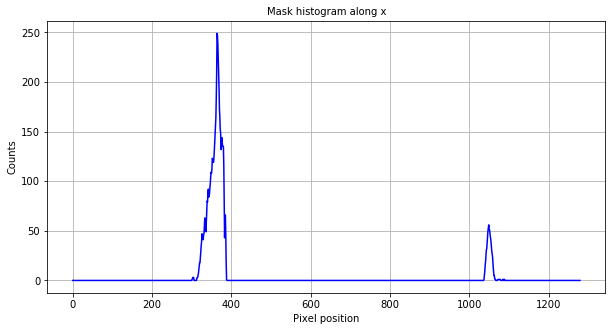

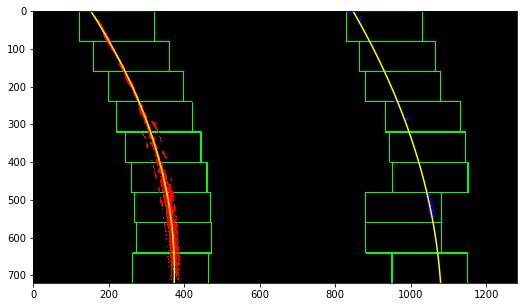

In [5]:
# 5) Detect line pixels and fit to find the lane boundary.
left_fit, right_fit = [], []
#  find_lines and returns the 2nd order polynomial coefficients
print('Finding lines without any a priori information')
left_fit, right_fit = find_lines(mask_warp,left_fit,right_fit,left_flag=0,right_flag=0,savepath=image_path[:-4]+'_fit1.jpg')  

Finding lines with previous polynomial coefficients of both lines as input


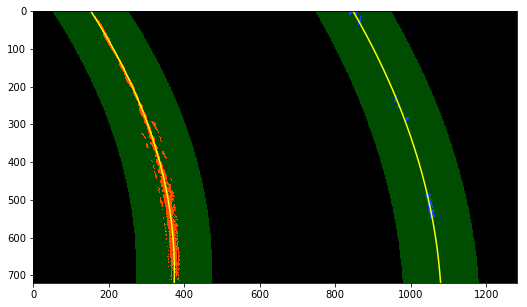

In [6]:
# idem but with previous polynomial coefficients as input    
print('Finding lines with previous polynomial coefficients of both lines as input')
left_fit, right_fit = find_lines(mask_warp,left_fit,right_fit,left_flag=1,right_flag=1,savepath=image_path[:-4]+'_fit2.jpg')

Finding lines with previous polynomial coefficients of left line as input


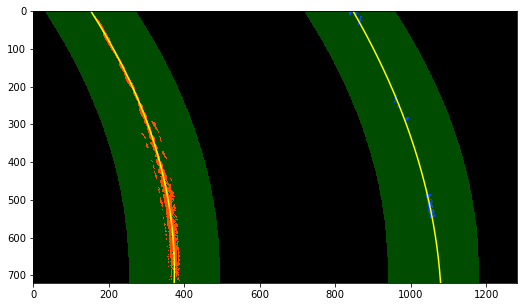

In [7]:
# idem but with previous polynomial coefficients as input    
print('Finding lines with previous polynomial coefficients of left line as input')
left_fit, right_fit = find_lines(mask_warp,left_fit,right_fit,left_flag=1,right_flag=0,savepath=image_path[:-4]+'_fit3.jpg')

In [8]:
#%% 6) Determine the curvature of the lane and vehicle position with respect to center.
# Define conversions in x and y from pixels space to meters
# Conversion is based on the fact that width of a lane = 3.7m
# and length of the lane is 30 m
# Compute positions of line pixels
y_vec = np.linspace(0, mask_warp.shape[0]-1, mask_warp.shape[0] )
left_fitx = left_fit[0]*y_vec**2 + left_fit[1]*y_vec + left_fit[2]
right_fitx = right_fit[0]*y_vec**2 + right_fit[1]*y_vec + right_fit[2]
# Determine witdh of the lane at the base, then convert
lane_width = (xdr-xdl-2*off_x)
xm_per_pix = 3.7/lane_width # meters per pixel in x dimension
ym_per_pix = 30/720. # meters per pixel in y dimension

# convert polynomial coefficients from pixels to meters
left_fit_cr = xm_per_pix*left_fit/np.array([ym_per_pix**2,ym_per_pix,1])
right_fit_cr = xm_per_pix*right_fit/np.array([ym_per_pix**2,ym_per_pix,1])

# Calculate the new radii of curvature at different positions along vertical axis
y_vec_m = y_vec*ym_per_pix
left_curverad = ((1 + (2*left_fit_cr[0]*y_vec_m + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_vec_m + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

print('Mean left/right curvature radius (m) = %.1f, %.1f' %(np.mean(left_curverad),np.mean(right_curverad)))

# Compute offset from the center of the line
# take the last value for the base of the image
offset = ((left_fitx[-1]+right_fitx[-1])/2-x_size/2)*xm_per_pix
print( 'Offset from center of the lane (m) = %.3f' %(offset))

Mean left/right curvature radius (m) = 349.8, 462.7
Offset from center of the lane (m) = 0.458


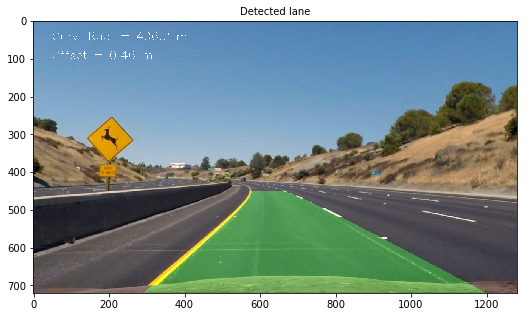

In [9]:
#%% 7) Warp the detected lane boundaries back onto the original image.
# Create an image to draw the lines on
warp_zero = np.zeros_like(mask_warp).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, y_vec]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, y_vec])))])
pts = np.hstack((pts_left, pts_right))

# 8) Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
Minv = np.linalg.inv(M)
newwarp = cv2.warpPerspective(color_warp, Minv, (x_size, y_size)) 
# Combine the result with the original image
out_img = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
# add curvature radius
curverad = np.mean((left_curverad + right_curverad)/2)
cv2.putText(out_img,'Curv. Rad. = {:.1f} m'.format(curverad), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, [255,255,255])
cv2.putText(out_img,'Offset = {:.2f} m'.format(offset), (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, [255,255,255])
plot_save_img(out_img,image_path[:-4]+'_lane.jpg',cmap='jet',title='Detected lane')